In [13]:
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

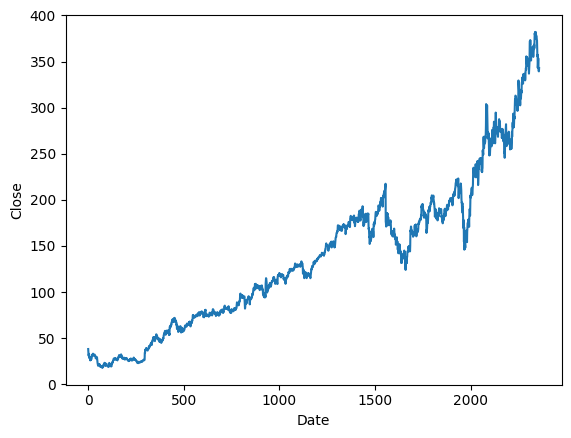

In [14]:
#LoadDataset

dataset = pd.read_csv("Dataset/FB_stock_history.csv")
dataset = dataset[["Date", "Close"]]

plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(dataset["Close"])
plt.show()

In [15]:
#Preprocess the dataset for training purpose
from copy import deepcopy as dc

def preprocess_data(dataset, lookback):
  dataset = dc(dataset)

  for i in range(1, lookback + 1):
    dataset[f"Close - {i}"] = dataset["Close"].shift(i)

  dataset.dropna(inplace = True)
  return dataset


dataset = preprocess_data(dataset, 7)
dataset = dataset.sample(frac = 1)
print(dataset)


            Date       Close   Close - 1   Close - 2   Close - 3   Close - 4  \
909   2015-12-30  106.220001  107.260002  105.930000  105.019997  104.629997   
2310  2021-07-26  372.459991  369.790009  351.190002  346.230011  341.660004   
181   2013-02-08   28.549999   28.650000   29.049999   28.639999   28.110001   
1957  2020-03-02  196.440002  192.470001  189.750000  197.199997  196.770004   
2237  2021-04-12  311.540009  312.459991  313.019989  313.089996  306.260010   
...          ...         ...         ...         ...         ...         ...   
2167  2020-12-29  276.779999  277.000000  267.399994  268.109985  267.089996   
170   2013-01-24   31.080000   30.820000   30.730000   29.660000   30.139999   
366   2013-11-01   49.750000   50.209999   49.009998   49.400002   50.230000   
213   2013-03-27   26.090000   25.209999   25.129999   25.730000   25.740000   
1114  2016-10-21  132.070007  130.000000  130.110001  128.570007  127.540001   

       Close - 5   Close - 6   Close - 

In [16]:
#Split dataset into train and test
ratio = 0.93
train_index = len(dataset) * ratio
train_index = int(train_index)

X_train = dataset.iloc[0: train_index, 2:]
Y_train = dataset.iloc[0: train_index, 1]

X_test = dataset.iloc[train_index:, 2:]
Y_test = dataset.iloc[train_index:, 1]


In [17]:
#Processing data for training and testing
sc = MinMaxScaler()
X_train = X_train.to_numpy().astype(np.float32)
X_train = sc.fit_transform(X_train)
X_test = X_test.to_numpy().astype(np.float32)
X_test = sc.fit_transform(X_test)
Y_train = Y_train.to_numpy().astype(np.float32)
Y_test = Y_test.to_numpy().astype(np.float32)
Y_train = sc.fit_transform(Y_train.reshape(-1, 1))
Y_test = sc.fit_transform(Y_test.reshape(-1, 1))
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

X_train = X_train.view(-1, 7, 1)
Y_train = Y_train.view(-1, 1)
X_test = X_test.view(-1, 7, 1)
Y_test = Y_test.view(-1, 1)
class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

train_dataset = CustomDataset(X_train, Y_train)
test_dataset = CustomDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True)


In [18]:
#Prediction model 
class TimeSeriesModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first= True)

    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

module = TimeSeriesModel(1, 4, 1)

In [19]:
#Training

loss = nn.MSELoss()
optimizer = torch.optim.Adam(module.parameters(), lr = 0.001)
num_epoch = len(train_dataloader)

for epoch in range (100):
  for input, output in train_dataloader:
    y_pred = module(input)

    l = loss(y_pred, output)
    l.backward()

    optimizer.step()
    optimizer.zero_grad()

    # if epoch % 10 == 0:
    #   print(f"Epoch: {epoch}, Loss: {l}")

In [20]:
#validation

with torch.no_grad():
  running_loss = 0.0
  loss_fn = nn.MSELoss()

  for input, output in test_dataloader:
    y_pred = module(input)
    l = loss_fn(y_pred, output)
    running_loss += l.item()

  avg_loss_across_batches = running_loss / len(test_dataloader)
  print('Average Val Loss: {0:.3f}'.format(avg_loss_across_batches))



Average Val Loss: 0.001


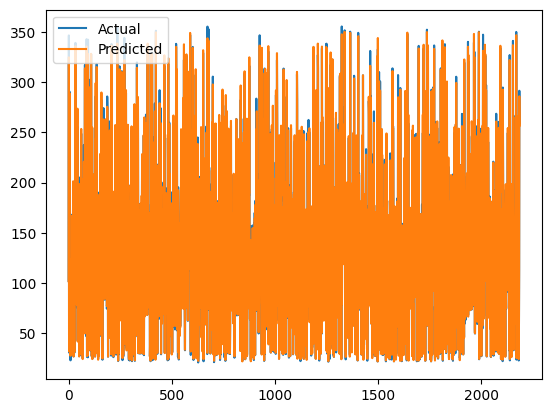

In [21]:
#After trained

with torch.no_grad():
  y_pred = module(X_train)
  y_pred = y_pred.numpy()
  y_pred = sc.inverse_transform(y_pred.reshape(-1, 1))
  Y_train = Y_train.numpy()
  Y_train = sc.inverse_transform(Y_train.reshape(-1, 1))
  plt.plot(Y_train, label = "Actual")
  plt.plot(y_pred, label = "Predicted")
  plt.legend()
  plt.show()

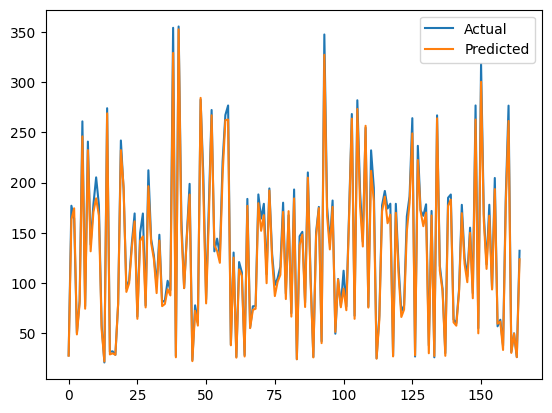

In [22]:
#Test

with torch.no_grad():
  y_pred = module(X_test)
  y_pred = y_pred.numpy()
  y_pred = sc.inverse_transform(y_pred.reshape(-1, 1))
  Y_test = Y_test.numpy()
  Y_test = sc.inverse_transform(Y_test.reshape(-1, 1))
  plt.plot(Y_test, label = "Actual")
  plt.plot(y_pred, label = "Predicted")
  plt.legend()
  plt.show()


